In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt

In [6]:
raw_train_data = pd.read_csv('./data/train.csv', index_col = 'PassengerId')
raw_test_data = pd.read_csv('./data/test.csv', index_col = 'PassengerId')

In [7]:
train_data = raw_train_data.drop(['Name', 'Ticket', 'Cabin'], axis=1)
test_data = raw_test_data.drop(['Name', 'Ticket', 'Cabin'], axis=1)

Name, Ticket, Cabin Feature는 큰 의미가 없을것이라 판단.<br>
Column 삭제

------
**Feedback**<br>
®삭제하려면 삭제할 수 있는 근거가 있어야 한다.<br>
규칙이 없어 보여도 그 안에 무엇인가 있을 수 있음<br><br>

여기서 근거를 찾아보자

| Variable | 삭제 이유                                                    |
| -------- | ------------------------------------------------------------ |
| Name     | *Mrs, Miss, Mr* 가 있으므로 성별과 혼인 여부 알 수 있음.<br> 1. 성별 => **Sex** Feature<br>  2. 혼인한 사람중에 배우자가 같이 동승한 경우 => **Sibsp** Feature<br> 3. 혼인했는데 배우자가 동승하지 않은 경우 => 큰 의미 없다고 판단 |
| Ticket <br> Cabin   |  다 고유한 번호들로 느껴져서 안지울 수가 없음            |



In [47]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 102.6+ KB


### Null 있는지 확인
'Age'에 177개 <br>
'Embarked'에 2개 null확인됬음. 


In [16]:
print(train_data['Age'].isnull().sum())
print(train_data['Embarked'].isnull().sum())

177
2



------
**Feedback**<br>
Fare를 잘 보면 0 값들이 있다(총 15개).<br>
이 사람들 무료로 탄걸까?<br>
아마 아니겠지. <br>
기록이 잘 안된거겠지. <br>
이 친구들도 채워 보자

In [20]:
train_data.loc[train_data.Fare == 0]['Fare'].count()

15

먼저 히스토그램 그려서 분포를 보자

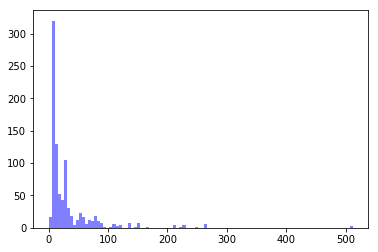

In [36]:
num_bins = 100
n, bins, patches = plt.hist(train_data['Fare'], num_bins, facecolor='blue', alpha=0.5)
plt.show()

Right Skewed 이 경우에는 Median이 더 Mode에 가까움. <br>
Median으로 채우자

In [43]:
change_median=train_data.Fare.replace({0: train_data['Fare'].median()})
(change_median==0).sum()

0

In [46]:
train_data['Fare'] = change_median

### Good!

### Value Counts for Categorical Data

In [11]:
category_list = ['Survived', 'Pclass', 'Sex', 'Embarked']
for i in category_list:
    print(i,' Value Counts')
    counts = train_data[i].value_counts()
    print(counts)
    if(counts.sum() != 891):
        print('This Data has', 891-counts.sum() ,'null value')
    print('---------------------')

Survived  Value Counts
0    549
1    342
Name: Survived, dtype: int64
---------------------
Pclass  Value Counts
3    491
1    216
2    184
Name: Pclass, dtype: int64
---------------------
Sex  Value Counts
male      577
female    314
Name: Sex, dtype: int64
---------------------
Embarked  Value Counts
S    644
C    168
Q     77
Name: Embarked, dtype: int64
This Data has 2 null value
---------------------


편향된 데이터가 있는지 체크<br>
잘 모르겠음.

In [12]:
train_data['Pclass'].value_counts().sum()

891

### Describe for Numerical Data

In [13]:
train_data[['Age', 'SibSp', 'Parch', 'Fare']].describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


array([[<matplotlib.axes._subplots.AxesSubplot object at 0xd26bd8d68>,
      dtype=object)

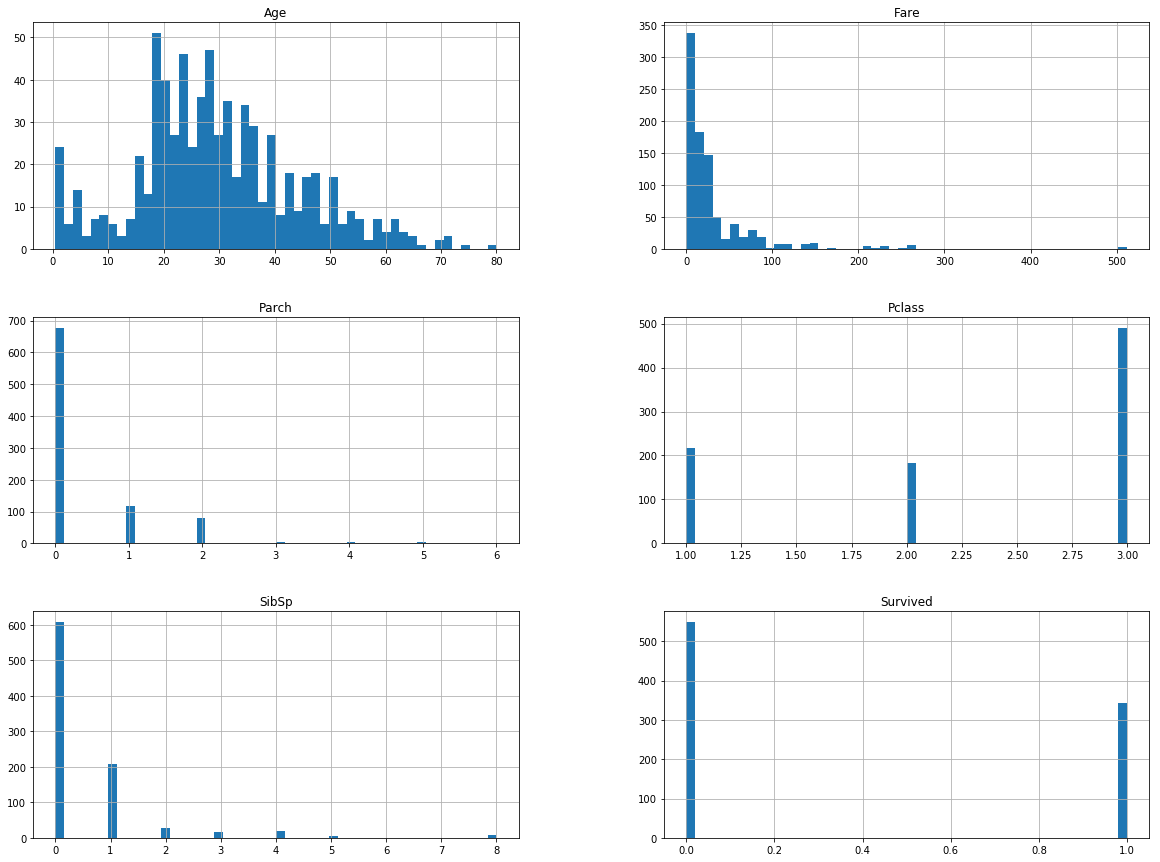

In [14]:
train_data.hist(bins=50, figsize=(20, 15))

### Correlation Coefficients

In [15]:
test_data.corr()

,Pclass,Age,SibSp,Parch,Fare
Pclass,1.000000,-0.492143,0.001087,0.018721,-0.577147
Age,-0.492143,1.000000,-0.091587,-0.061249,0.337932
SibSp,0.001087,-0.091587,1.000000,0.306895,0.171539
Parch,0.018721,-0.061249,0.306895,1.000000,0.230046
Fare,-0.577147,0.337932,0.171539,0.230046,1.000000


In [16]:
len(train_data['Sex'].value_counts().index)

2

In [19]:
train_data_1=train_data
train_data_1['Sex']=train_data['Sex'].replace({'male':1 ,'female': 2})
train_data_1['Embarked']=train_data_1['Embarked'].replace({'C': 1, 'Q':2, 'S':3})

In [20]:
train_data_1.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,1.000000,-0.338481,0.543351,-0.077221,-0.035322,0.081629,0.257307,-0.169718
Pclass,-0.338481,1.000000,-0.131900,-0.369226,0.083081,0.018443,-0.549500,0.164681
Sex,0.543351,-0.131900,1.000000,-0.093254,0.114631,0.245489,0.182333,-0.110320
Age,-0.077221,-0.369226,-0.093254,1.000000,-0.308247,-0.189119,0.096067,-0.032565
SibSp,-0.035322,0.083081,0.114631,-0.308247,1.000000,0.414838,0.159651,0.068900
Parch,0.081629,0.018443,0.245489,-0.189119,0.414838,1.000000,0.216225,0.040449
Fare,0.257307,-0.549500,0.182333,0.096067,0.159651,0.216225,1.000000,-0.226311
Embarked,-0.169718,0.164681,-0.110320,-0.032565,0.068900,0.040449,-0.226311,1.000000


In [21]:
train_data.groupby('Sex').sum()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked
Sex,,,,,,,
1,109,1379,13919.17,248,136,14727.2865,1500.0
2,233,678,7286.00,218,204,13966.6628,754.0


In [22]:
#Number of non-null observations
train_data.groupby('Sex').count()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked
Sex,,,,,,,
1,577,577,453,577,577,577,577
2,314,314,261,314,314,314,312


**Insight 1** 
여자는 대부분 살고 남자는 대부분 죽었음. 

In [23]:
train_data.groupby('Pclass').sum()['Survived'] / train_data.groupby('Pclass').count()['Survived']


Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

**Insight 2** 
1등석이 확실히 더 많이 살았음.

In [24]:
train_data.groupby('Embarked').sum()['Survived'] / train_data.groupby('Embarked').count()['Survived']

Embarked
1.0    0.553571
2.0    0.389610
3.0    0.336957
Name: Survived, dtype: float64

**Insight 3** 
Cherbourg에서 승선한 사람은 50% 넘게 살았음 <br>
출구 쪽에 있었나?<br>
혹시 가장 마지막에 탑승했거나, 비상구에서 가까운 쪽에 위치하고 있었나?

In [25]:
print(train_data.groupby('SibSp').sum()['Survived'] / train_data.groupby('SibSp').count()['Survived'])
print(train_data.groupby('Parch').sum()['Survived'] / train_data.groupby('Parch').count()['Survived'])


SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64
Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64


이건 딱히 얻을게 있는지 잘 모르겠다. 

In [26]:
train_data.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,889.000000
mean,0.383838,2.308642,1.352413,29.699118,0.523008,0.381594,32.204208,2.535433
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.792088
min,0.000000,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,1.000000,20.125000,0.000000,0.000000,7.910400,2.000000
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,3.000000
75%,1.000000,3.000000,2.000000,38.000000,1.000000,0.000000,31.000000,3.000000
max,1.000000,3.000000,2.000000,80.000000,8.000000,6.000000,512.329200,3.000000


In [27]:
bins = [x for x in range(-1, 81, 10)]

In [28]:
train_data_with_ages = train_data.copy()
train_data_with_ages['cut'] = pd.cut(train_data_with_ages['Age'],
                              bins=bins, include_lowest = True)
train_data_with_ages

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cut
PassengerId,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,3.0,"(19.0, 29.0]"
2,1,1,2,38.0,1,0,71.2833,1.0,"(29.0, 39.0]"
3,1,3,2,26.0,0,0,7.9250,3.0,"(19.0, 29.0]"
4,1,1,2,35.0,1,0,53.1000,3.0,"(29.0, 39.0]"
5,0,3,1,35.0,0,0,8.0500,3.0,"(29.0, 39.0]"
6,0,3,1,NaN,0,0,8.4583,2.0,NaN
7,0,1,1,54.0,0,0,51.8625,3.0,"(49.0, 59.0]"
8,0,3,1,2.0,3,1,21.0750,3.0,"(-1.001, 9.0]"
9,1,3,2,27.0,0,2,11.1333,3.0,"(19.0, 29.0]"


In [29]:
print(train_data_with_ages.groupby('cut').sum()['Survived'] / train_data_with_ages.groupby('cut').count()['Survived'])



cut
(-1.001, 9.0]    0.612903
(9.0, 19.0]      0.401961
(19.0, 29.0]     0.350000
(29.0, 39.0]     0.437126
(39.0, 49.0]     0.382022
(49.0, 59.0]     0.416667
(59.0, 69.0]     0.315789
(69.0, 79.0]     0.000000
Name: Survived, dtype: float64


**나이대 별로 보면** 애기들이 확실히 더 많이 살긴 했는데 유의미한지는 잘 모르겠음. 


**가장 중요한 Feature는 Sex, Pclass**

In [30]:
train_data.groupby(['Sex', 'Pclass']).sum()['Survived'] / train_data.groupby(['Sex', 'Pclass']).count()['Survived']


Sex  Pclass
1    1         0.368852
     2         0.157407
     3         0.135447
2    1         0.968085
     2         0.921053
     3         0.500000
Name: Survived, dtype: float64

In [31]:
train_data.groupby(['Pclass', 'Sex']).sum()['Survived'] / train_data.groupby(['Pclass', 'Sex']).count()['Survived']

Pclass  Sex
1       1      0.368852
        2      0.968085
2       1      0.157407
        2      0.921053
3       1      0.135447
        2      0.500000
Name: Survived, dtype: float64

현재 여자가 Sex 2번, <br>
***여자 + 1등석 96.8% 생존***<br>
***여자 + 2등석 92.1% 생존***

In [41]:
pclass_sex = train_data.groupby(['Pclass', 'Sex']).sum()['Survived'] / train_data.groupby(['Pclass', 'Sex']).count()['Survived']

In [45]:
n_groups = 3
women_survived = []
men_survived= []
for i in range(1, 4):
    men_survived.append(pclass_sex[i][1])
    women_survived.append(pclass_sex[i][2])
    

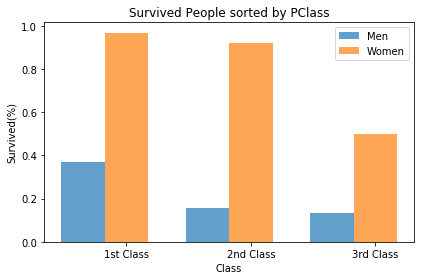

In [46]:

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.7
 
rects1 = plt.bar(index, men_survived, bar_width,
                 alpha=opacity,
                 label='Men')
 
rects2 = plt.bar(index + bar_width, women_survived, bar_width,
                 alpha=opacity,
                 label='Women')
 
plt.xlabel('Class')
plt.ylabel('Survived(%)')
plt.title('Survived People sorted by PClass')
plt.xticks(index + bar_width, ('1st Class', '2nd Class', '3rd Class'))
plt.legend()
 
plt.tight_layout()
plt.show()

In [60]:
sex_pclass= train_data.groupby(['Sex', 'Pclass']).sum()['Survived'] / train_data.groupby(['Sex', 'Pclass']).count()['Survived']


In [61]:
sex_pclass

Sex  Pclass
1    1         0.368852
     2         0.157407
     3         0.135447
2    1         0.968085
     2         0.921053
     3         0.500000
Name: Survived, dtype: float64

In [52]:
sex_list = ['male', 'female']

In [62]:
n_groups = 2
first_survived = []
second_survived= []
third_survived =[]
for i in [1, 2]:
    first_survived.append(sex_pclass[i][1])
    second_survived.append(sex_pclass[i][2])
    third_survived.append(sex_pclass[i][3])


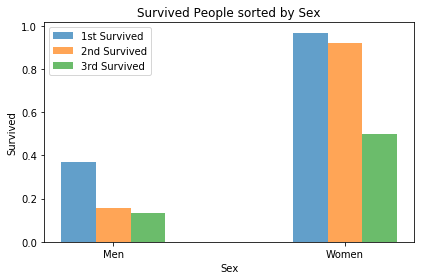

In [63]:
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.7
 
rects1 = plt.bar(index, first_survived, bar_width,
                 alpha=opacity,
                 label='1st Survived')
 
rects2 = plt.bar(index + bar_width, second_survived, bar_width,
                 alpha=opacity,
                 label='2nd Survived')
rects3 = plt.bar(index + bar_width+bar_width, third_survived, bar_width,
                 alpha=opacity,
                 label='3rd Survived')

 
plt.xlabel('Sex')
plt.ylabel('Survived')
plt.title('Survived People sorted by Sex')
plt.xticks(index + bar_width, ('Men', 'Women'))
plt.legend()
 
plt.tight_layout()
plt.show()

# 9/23 Sun PM 5 : 20 ~ 6 : 30

## Data Preprocessing For Maching Learning

#### 일단 Null값들 처리해야됨. 
null이 있었던 column은 총 2개 -> Age, Embarked

In [64]:
pre_train_data = train_data.copy()

In [65]:
pre_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int64
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null float64
dtypes: float64(3), int64(5)
memory usage: 62.6 KB


age에 null이 좀 많고, <br>
embarked에는 2개<br>
embarked row는 어쩔 수 없이 날려야 될 것 같고, <br>
age는 평균 나이로 채우자

In [66]:
pre_train_data = pre_train_data.dropna(subset=["Embarked"])

In [67]:
age_mean = int(pre_train_data['Age'].mean())
pre_train_data['Age'].fillna(age_mean, inplace=True)

In [68]:
pre_train_data.index.drop

<bound method Index.drop of Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            882, 883, 884, 885, 886, 887, 888, 889, 890, 891],
           dtype='int64', name='PassengerId', length=889)>

In [69]:
pre_train_data = pre_train_data.reset_index(drop=True)

In [70]:
train_y = pd.DataFrame(pre_train_data['Survived'])
train_x = pre_train_data.drop(['Survived'], axis=1)

One-Hot Encoding<br>
Y - Survived <br>
X - pclasss, sex, embarked 를 one-hot encoding 해야 함. 

In [71]:
pclass_encoded = pd.get_dummies(train_x['Pclass'])
sex_encoded = pd.get_dummies(train_x['Sex'])
embarked_encoded = pd.get_dummies(train_x['Embarked'])
y_encoded = pd.get_dummies(train_y['Survived'])

In [72]:
train_x_encoded = train_x.drop(['Pclass', 'Embarked', 'Sex'],axis=1)
train_y_encoded = y_encoded

In [73]:
train_x_encoded = pd.concat([train_x_encoded ,pclass_encoded, sex_encoded, embarked_encoded], axis=1)

#### Feature Scaling
Age, Fare, SibSp, Parch를 Scaling 할 것<br>
stdscaler or MinMax Scaler?

In [74]:
from sklearn.preprocessing import StandardScaler

In [75]:
stdscaler = StandardScaler()

In [76]:
before_scaler = train_x_encoded[['Age', 'Fare', 'SibSp', 'Parch']]

In [77]:
after_scaler = pd.DataFrame(stdscaler.fit_transform(before_scaler),
             columns=before_scaler.columns)

In [78]:
drop_x= train_x_encoded.drop(['Age', 'Fare', 'SibSp', 'Parch'],
                                                 axis= 1)

In [79]:
train_x_scaled = pd.concat([after_scaler, drop_x], axis = 1)

In [80]:
train_x_scaled.shape

(889, 12)

train x : train_x_scaled<br>
train y : train_y_encoded

In [81]:
X = train_x_scaled.values
y = train_y.values.flatten()

# Logitstic Regression

In [85]:
from sklearn.model_selection import cross_val_score

In [45]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
scores = cross_val_score(log_reg, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores)
print("mean: ", np.mean(rmse_scores))
print("Standard Deviation: ", np.std(rmse_scores))

[0.47404546 0.44971901 0.48575205 0.41053541 0.44971901 0.47404546
 0.46204236 0.46204236 0.41053541 0.38435306]
mean:  0.44627896177490534
Standard Deviation:  0.031639753109121246


### Softmax

In [47]:
solver_list = ['lbfgs','sag', 'saga']

In [48]:
for i in solver_list:
    softmax_reg = LogisticRegression(multi_class="multinomial", solver=i, C=10)
    softmax_reg.fit(X, y)
    scores = cross_val_score(softmax_reg, X, y, scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-scores)
    print('solver', i, ' scores')
    print("mean: ", np.mean(rmse_scores))
    print("Standard Deviation: ", np.std(rmse_scores))

solver lbfgs  scores
mean:  0.44762533561236173
Standard Deviation:  0.03035029033192375
solver sag  scores
mean:  0.44762533561236173
Standard Deviation:  0.03035029033192375
solver saga  scores
mean:  0.44762533561236173
Standard Deviation:  0.03035029033192375


# 9/23 Sun PM 11 : 40 ~  0 : 30

# Support Vector Machine

### Linear SVM Classifier

In [49]:
from sklearn.svm import LinearSVC

In [50]:
c_dict = {}
for i in range(1, 500, 20):
    linear_svc =LinearSVC(C =i, loss="hinge")
    linear_svc.fit(X, y)
    scores = cross_val_score(linear_svc, X, y, scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-scores)
    c_dict[i]=np.mean(rmse_scores)
    
    
for key, value in c_dict.items():
    if value == max(c_dict.values()):
        print("The Best C value is", key)
        print("The rmse of C=", key, "is ", value)

The Best C value is 421
The rmse of C= 421 is  0.5707476196902691


### Non-Linear SVM Classifier

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [ ]:
p_dict ={}

for i in list([2, 3, 4]):
    poly_features = PolynomialFeatures(degree=i)
    x_poly = poly_features.fit_transform(X)
    
    for j in range(1, 500, 20):
        linear_svc = LinearSVC(C =j, loss="hinge")
        linear_svc.fit(x_poly, y)
        scores = cross_val_score(linear_svc, x_poly, y, scoring="neg_mean_squared_error", cv=10)
        rmse_scores = np.sqrt(-scores)
        p_dict[i, j]=np.mean(rmse_scores)
        #i= degree, j=C
                
    
for key, value in p_dict.items():
    if value == max(p_dict.values()):
        print("The Best C value is", key[1])
        print("The Best Degree value is", key[0])
        print("The rmse is ", value)            

### Polynomial Kernel

In [101]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [102]:
degree_param = [x for x in range(2, 5)]
coef0_param = [x for x in range(1, 100, 10)]
C_param = [x for x in range(1, 500, 50)]
param_grid = [
    {'degree': degree_param, 'coef0': coef0_param, 'C': C_param }
]
#degree, coef, C

In [103]:
svm_clf = SVC(kernel="poly")
grid_search = GridSearchCV(svm_clf, param_grid, cv=5,
                           scoring="neg_mean_squared_error",
                           return_train_score=True)

In [ ]:
grid_search.fit(X, y)
#이거 왜 이렇게 오래 걸리지

In [ ]:
grid_search.best_params

In [79]:
svm_clf  = SVC(kernel="poly", degree=3, coef0=5, C=10)
scores = cross_val_score(linear_svc, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print(np.mean(rmse_scores))

0.5580047101940405


### 가우시안 BRF Kernel

In [84]:
svm_clf  = SVC(kernel="rbf", gamma=5, coef0=5, C=0.001)
scores = cross_val_score(linear_svc, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print(np.mean(rmse_scores))

0.5576648819896322


# 9/24 Mon AM 1 : 30 ~  2 : 45

# Decision Regression

In [82]:
from sklearn.tree import DecisionTreeClassifier

In [120]:
tree_reg = DecisionTreeClassifier(min_samples_leaf=1, max_features=1)

In [121]:
scores = cross_val_score(tree_reg, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print("mean: ", np.mean(rmse_scores))
print("Standard Deviation: ", np.std(rmse_scores))

mean:  0.48656835176636326
Standard Deviation:  0.024454477921571842


# RandomForest Regression

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [192]:
forest_reg = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)

In [193]:
scores = cross_val_score(forest_reg, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores)
print("mean: ", np.mean(rmse_scores))
print("Standard Deviation: ", np.std(rmse_scores))

[0.43704832 0.42399915 0.49718308 0.33520076 0.33520076 0.42399915
 0.44971901 0.47404546 0.36719404 0.42640143]
mean:  0.41699911716208843
Standard Deviation:  0.052158611561197644


# Ensemble Training

### Voting

In [123]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [145]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf_hard = SVC()
svm_clf_soft = SVC(probability=True)

voting_clf_hard = VotingClassifier(
        estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf_hard)],
        voting= 'hard')

voting_clf_soft=VotingClassifier(
        estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf_soft)],
        voting= 'soft')


In [155]:
y1=y.reshape((-1, 1))
print(y1.shape)
print(y.shape)

(889, 1)
(889,)


In [156]:
scores = cross_val_score(voting_clf_soft, X, y1, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores)
print("mean: ", np.mean(rmse_scores))
print("Standard Deviation: ", np.std(rmse_scores))

/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array wa

[0.43704832 0.41053541 0.47404546 0.36719404 0.39661489 0.44971901
 0.39661489 0.43704832 0.39661489 0.41286141]
mean:  0.41782966526516796
Standard Deviation:  0.029846133116151776


/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. R

### Bagging and Pasting

In [157]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [187]:
bag_clf = BaggingClassifier(
        LogisticRegression(), n_estimators = 50,
        max_samples=50, bootstrap=True, n_jobs=-1
)

In [188]:
bag_clf.fit(X, y)

BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=50, n_estimators=50, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [189]:
scores = cross_val_score(bag_clf, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores)
print("mean: ", np.mean(rmse_scores))
print("Standard Deviation: ", np.std(rmse_scores))

[0.47404546 0.46204236 0.48575205 0.39661489 0.47404546 0.47404546
 0.46204236 0.47404546 0.39661489 0.45226702]
mean:  0.4551515428989859
Standard Deviation:  0.030529786920650517


In [185]:
bag_clf = BaggingClassifier(
        LogisticRegression(), n_estimators = 50,
        max_samples=50, bootstrap=False, n_jobs=-1
)

In [186]:
scores = cross_val_score(bag_clf, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores)
print("mean: ", np.mean(rmse_scores))
print("Standard Deviation: ", np.std(rmse_scores))

[0.44971901 0.46204236 0.47404546 0.39661489 0.44971901 0.46204236
 0.46204236 0.48575205 0.39661489 0.46466019]
mean:  0.45032526020721153
Standard Deviation:  0.028645087193594935


# Boosting

### Ada Boost

In [194]:
from sklearn.ensemble import AdaBoostClassifier

In [208]:
ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(), n_estimators=200,
        algorithm="SAMME.R", learning_rate=0.05
)

In [209]:
scores = cross_val_score(ada_clf, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores)
print("mean: ", np.mean(rmse_scores))
print("Standard Deviation: ", np.std(rmse_scores))

[0.55079106 0.49718308 0.50835712 0.41053541 0.35156152 0.48575205
 0.42399915 0.50835712 0.41053541 0.47673129]
mean:  0.46238032316166633
Standard Deviation:  0.057565023687095485


In [210]:
ada_clf = AdaBoostClassifier(
        LogisticRegression(), n_estimators=200,
        algorithm="SAMME.R", learning_rate=0.05
)

In [211]:
scores = cross_val_score(ada_clf, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores)
print("mean: ", np.mean(rmse_scores))
print("Standard Deviation: ", np.std(rmse_scores))

[0.44971901 0.46204236 0.48575205 0.39661489 0.41053541 0.44971901
 0.43704832 0.48575205 0.38218767 0.45226702]
mean:  0.44116378083588986
Standard Deviation:  0.033316104357096483
